In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt

## 7.2 Conversion Testing Recap

In [3]:
visitors_to_A = 1300
visitors_to_B = 1275

conversions_from_A = 120
conversions_from_B = 125

In [4]:
alpha_prior = 1
beta_prior = 1

In [5]:
posterior_a = tfp.distributions.Beta(
    alpha_prior + conversions_from_A, 
    beta_prior + visitors_to_A - conversions_from_A)

posterior_b = tfp.distributions.Beta(
    alpha_prior + conversions_from_B, 
    beta_prior + visitors_to_B - conversions_from_B)

In [6]:
figsize = (12.5, 4)
x = np.linspace(0,1,500)

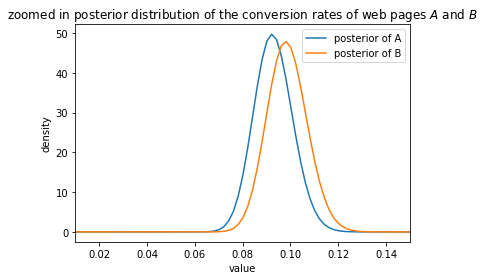

In [7]:
plt.plot(x, posterior_a.prob(x), label='posterior of A')
plt.plot(x, posterior_b.prob(x), label='posterior of B')
plt.xlim(0.01, 0.15)
plt.xlabel('value')
plt.ylabel('density')
plt.title("zoomed in posterior distribution of the conversion rates of web pages $A$ and $B$")
plt.legend()

## 7.3 Adding a linear loss function

### 7.3.1 Expected revenue analysis

In [8]:
N = 1
p = [0.5, 0.2, 0.3]
tfp.distributions.Multinomial(N, probs=p).sample().numpy()

array([0., 1., 0.], dtype=float32)

In [9]:
N=10
tfp.distributions.Multinomial(N, probs=p).sample().numpy()

array([6., 1., 3.], dtype=float32)

In [10]:
sample = tfp.distributions.Dirichlet([1,1]).sample().numpy()
sample

array([0.7016795, 0.2983205], dtype=float32)

In [11]:
sample.sum()

1.0

In [12]:
sample = tfp.distributions.Dirichlet([1,1,1,1]).sample().numpy()
sample

array([0.43452305, 0.22693825, 0.28736347, 0.05117525], dtype=float32)

In [13]:
sample.sum()

1.0

In [14]:
N = 1000
N_79 = 10
N_49 = 46
N_25 = 80
N_0 = N - (N_79 + N_49 + N_25)

In [15]:
observations = tf.constant([N_79, N_49, N_25, N_0], dtype=float)
prior_parameters = tf.constant([1,1,1,1], dtype=float)

In [16]:
posterior_samples = tfp.distributions.Dirichlet(observations + prior_parameters).sample(10000).numpy()

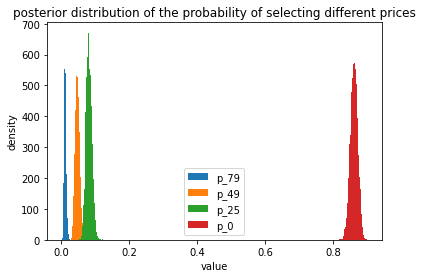

In [17]:
for i, label in enumerate(['p_79', 'p_49', 'p_25', 'p_0']):
    ax = plt.hist(posterior_samples[:,i], bins=50, label=label, histtype='stepfilled')
    
plt.xlabel('value')
plt.ylabel('density')
plt.title('posterior distribution of the probability of selecting different prices')
plt.legend()

In [18]:
def expected_revenue(p):
    return np.dot(p, np.array([79, 49, 25, 0]))

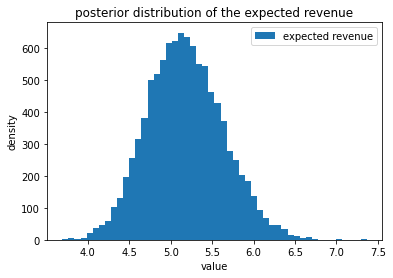

In [19]:
posterior_expected_revenue = expected_revenue(posterior_samples)
plt.hist(posterior_expected_revenue, bins=50, label='expected revenue', histtype='stepfilled')
plt.xlabel('value')
plt.ylabel('density')
plt.title('posterior distribution of the expected revenue')
plt.legend()

### 7.3.2 Extending to an A/B experiment

In [20]:
N_A = 1000
N_A_79 = 10
N_A_49 = 46
N_A_25 = 80
N_A_0 = N_A - (N_A_79 + N_A_49 + N_A_25)
observations_A = tf.constant([N_A_79, N_A_49, N_A_25, N_A_0], dtype=float)
observations_A

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 10.,  46.,  80., 864.], dtype=float32)>

In [21]:
N_B = 2000
N_B_79 = 45
N_B_49 = 84
N_B_25 = 200
N_B_0 = N_B - (N_B_79 + N_B_49 + N_B_25)
observations_B = tf.constant([N_B_79, N_B_49, N_B_25, N_B_0], dtype=float)
observations_B

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([  45.,   84.,  200., 1671.], dtype=float32)>

In [22]:
prior_parameters = tf.ones(4)
prior_parameters

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 1., 1., 1.], dtype=float32)>

In [23]:
posterior_samples_A = tfp.distributions.Dirichlet(observations_A + prior_parameters).sample(10000).numpy()

In [24]:
posterior_samples_B = tfp.distributions.Dirichlet(observations_B + prior_parameters).sample(10000).numpy()

In [25]:
posterior_expected_revenue_A = expected_revenue(posterior_samples_A)

In [26]:
posterior_expected_revenue_B = expected_revenue(posterior_samples_B)

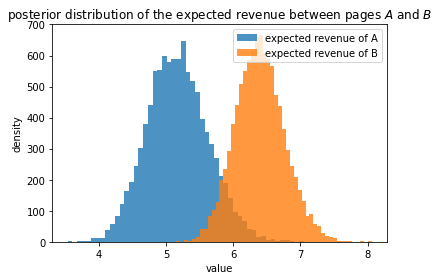

In [27]:
plt.hist(posterior_expected_revenue_A, bins=50, label='expected revenue of A', histtype='stepfilled', alpha=0.8)
plt.hist(posterior_expected_revenue_B, bins=50, label='expected revenue of B', histtype='stepfilled', alpha=0.8)
plt.xlabel('value')
plt.ylabel('density')
plt.title('posterior distribution of the expected revenue between pages $A$ and $B$')
plt.legend()

In [28]:
(posterior_expected_revenue_B > posterior_expected_revenue_A).mean()

0.9795

In [29]:
posterior_diff = posterior_expected_revenue_B - posterior_expected_revenue_A

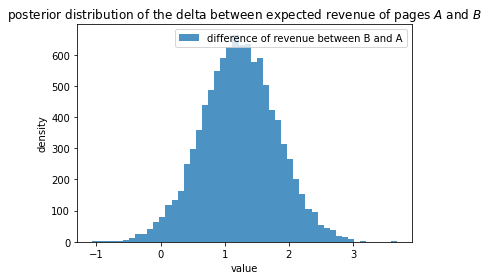

In [30]:
plt.hist(posterior_diff, bins=50, label='difference of revenue between B and A', histtype='stepfilled', alpha=0.8)
plt.xlabel('value')
plt.ylabel('density')
plt.title('posterior distribution of the delta between expected revenue of pages $A$ and $B$')
plt.legend()

## 7.4 Extending to an A/B experiment

In [31]:
N = 250
mu_A, std_A = 30, 4 
mu_B, std_B = 26, 7

In [32]:
durations_A = tfp.distributions.Normal(mu_A, std_A).sample(N)
durations_B = tfp.distributions.Normal(mu_B, std_B).sample(N)

In [33]:
pooled_mean = tf.math.reduce_mean(tf.stack([durations_A, durations_B]))
pooled_std = tf.math.reduce_std(tf.stack([durations_A, durations_B]))
tau = 1./tf.math.sqrt(1000.0*pooled_std)

In [34]:
def durations(durations_A, durations_B, mu_A, mu_B, std_A, std_B, tau):
    pooled_mean = tf.math.reduce_mean(tf.stack([durations_A, durations_B]))
    pooled_std = tf.math.reduce_std(tf.stack([durations_A, durations_B]))
    tau = 1./tf.math.sqrt(1000.0*pooled_std)

    durations_posterior_A = tfp.distributions.JointDistributionNamed(
        dict(
            x=tfp.distributions.Normal(mu_A, tau, name='mu_A'),
            y=tfp.distributions.Uniform(pooled_std/1000.0, 1000.0*pooled_std, name='std_A'),
            z=tfp.distributions.Exponential(1/29.0, name='nu-1'),
            obs=lambda x, y, z: tfp.distributions.Independent(
                tfp.distributions.StudentT(x, 1.0/y**2, z+1,name="obs_A"),
                reinterpreted_batch_ndims=0
            )
        )
    )
    
    durations_posterior_B = tfp.distributions.JointDistributionNamed(
        dict(
            x=tfp.distributions.Normal(mu_B, tau, name='mu_B'),
            y=tfp.distributions.Uniform(pooled_std/1000.0, 1000.0*pooled_std, name='std_B'),
            z=tfp.distributions.Exponential(1/29.0, name='nu-1'),
            obs=lambda x, y, z: tfp.distributions.Independent(
                tfp.distributions.StudentT(x, 1.0/y**2, z+1, name="obs_B"),
                reinterpreted_batch_ndims=0
            )
        )
    )
    return durations_posterior_A, durations_posterior_B

In [35]:
durations_posterior_A, durations_posterior_B = durations(
    durations_A, 
    durations_B, 
    mu_A,
    mu_B,
    std_A, 
    std_B, 
    tau
)

In [36]:
def log_prob_fn(model, x, y, z, obs):
    return model.log_prob(x=x, y=y, z=z, obs=obs)

In [37]:
@tf.function(autograph=False, experimental_compile=True)
def make_mcmc(log_prob_fn):
    kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=log_prob_fn,
      step_size=0.05,
      num_leapfrog_steps=3
    ),
   bijector=[
      tfb.Sigmoid(low=0., high=tf.cast(len(years), dtype=tf.float32)),
      tfb.Softplus(),
      tfb.Softplus(),
  ])